Necessary imports

In [2]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
import gpytorch
from gpytorch.models import ApproximateGP
from torch.distributions import Normal
import optuna
from optuna.trial import TrialState
import random
from sklearn.cluster import KMeans

# define the device for the setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# check the computer name and set the path accordingly
if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    sys.path.append(r'C:\Users\Surface\Masterarbeit')
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':  # desktop name
    sys.path.append(r'C:\Users\test\Masterarbeit')
    
else:
    raise ValueError("Unbekannter Computername: " + os.environ['COMPUTERNAME'])

import utils.data_prep as data_prep
import utils.metrices as metrices

In [2]:
SEED = 42

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

Transformation Pipeline for Approximating GPR

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test, feature_names = data_prep.load_tranform_and_split_data('C1_V01_delta_kan', split_ratio=(0.6, 0.2, 0.2))

# convert the data to PyTorch tensors
# and add an extra dimension for the target variable
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float() 
y_train_tensor = torch.from_numpy(y_train).float() # Add extra dimension for compatibility
y_val_tensor = torch.from_numpy(y_val).float()
y_test_tensor = torch.from_numpy(y_test).float()
print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)
print(feature_names)

if torch.cuda.is_available():
    X_train_tensor = X_train_tensor.cuda()
    X_val_tensor = X_val_tensor.cuda()
    X_test_tensor = X_test_tensor.cuda()
    y_train_tensor = y_train_tensor.cuda()
    y_val_tensor = y_val_tensor.cuda()
    y_test_tensor = y_test_tensor.cuda()

torch.Size([31206, 37]) torch.Size([10402, 37]) torch.Size([10403, 37])
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')


Stochastic Variational GP Regression Implementation

Natural Gradient Descent with Variational Models for better and faster convergence

In [4]:
#create a TensorDataset and DataLoader for the training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

class GPModel(ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module  = kernel

        self.mean_module.initialize(constant=y_train_tensor.mean().item())  # Initialize the mean to the mean of the training targets
        # self.covar_module.base_kernel.lengthscale = 1
        # y_var = y_train_tensor.var(unbiased=False)
        # self.covar_module.outputscale = y_var.item()
        #self.covar_module.outputscale = outputscale  # Initialize the outputscale to the variance of the training targets
                
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

print(y_train_tensor.var(unbiased=False).item())

58.64500427246094


In [14]:
def objective(trial):

    set_seed(SEED)
    # Estimate the variance of the training targets for initializing the likelihood noise
    y_var = y_train_tensor.var(unbiased=False).item()
    noise = 1e-2 * y_var

    # Suggest hyperparameters for optimization
    lr_ngd = trial.suggest_float('lr', 1e-3, 1e-1, log=True)
    lr_adam = trial.suggest_float('lr_adam', 1e-3, 1e-1, log=True)

    #Rational Quadratic Kernel
    rational_quadratic_kernel = gpytorch.kernels.RQKernel(ard_num_dims=X_train.shape[1], 
                                                        alpha_constraint=gpytorch.constraints.Interval(0.1, 10.0))
    rational_quadratic_kernel.lengthscale = torch.ones(X_train.shape[1])
    rational_quadratic_kernel.outputscale = y_var
    rational_quadratic_kernel1 = gpytorch.kernels.ScaleKernel(rational_quadratic_kernel)

    kernel = rational_quadratic_kernel1

    kernel_name = type(kernel.base_kernel).__name__
    #filename = f'Modelsaves/Apprx_GP_{kernel_name}_{idx}.pth'
    print(kernel_name)

    # Define the inducing points
    # Randomly select 1000 inducing points from the training data
    num_inducing_points = 1000

    kmeans = KMeans(n_clusters=num_inducing_points, random_state=42).fit(X_train)
    inducing_points = torch.from_numpy(kmeans.cluster_centers_).float()

    model = GPModel(inducing_points = inducing_points, kernel=kernel)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise = noise

    print(f'Model: {model}')
    print(f'Mean: {model.mean_module.constant.item()}')
    print(f'Lengthscale: {model.covar_module.base_kernel.lengthscale}')
    print(f'Outputscale: {model.covar_module.outputscale}')
    print(f'Likelihood Noise: {likelihood.noise.item()}')
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()

    num_epochs = 100

    model.train()
    likelihood.train()

    variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data= y_train_tensor.size(0), lr=lr_ngd)

    hyperparameter_optimizer = torch.optim.Adam([
        {'params': model.hyperparameters()},
        {'params': likelihood.parameters()},
    ], lr=lr_adam)

    # VariationalELBO is used for training
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(train_loader.dataset))

    best_val_loss = np.inf
    patience = 10
    epochs_no_improve = 0
    decimal_places = 3
    tolerance = 10 ** (-decimal_places)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        model.train()
        likelihood.train()
        for x_batch, y_batch in train_loader:
            # Zero gradients from previous iteration        
            variational_ngd_optimizer.zero_grad()
            hyperparameter_optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            # Print the loss for every tenth batch
            loss.backward()
            variational_ngd_optimizer.step()
            hyperparameter_optimizer.step()

            epoch_loss += loss.item()
        # print every ten epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}')         # Print the average loss for the epoch

        model.eval()
        likelihood.eval()
        
        with torch.no_grad():
            f_val_preds = model(X_val_tensor)
            val_loss = -mll(f_val_preds, y_val_tensor).item()  
            
            val_preds = likelihood(f_val_preds)     
            val_mean = val_preds.mean.cpu()
            val_std = val_preds.stddev.cpu()
            val_std = val_std.clamp_min(1e-6)
            nll_per_point = -Normal(val_mean, val_std).log_prob(y_val_tensor.cpu()).numpy()
            val_nll = nll_per_point.mean().item()
            
            r2_score_val = r2_score(y_val, val_mean)
            if (epoch + 1) % 10 == 0:
                print(f'Validation Loss: {val_loss} Validation NLL: {val_nll} R²: {r2_score_val:.3f}')

            trial.report(val_loss, step=epoch)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

            if abs(val_nll - best_val_loss) < tolerance:

                epochs_no_improve += 1
            else:
                epochs_no_improve = 0
                best_val_loss = val_loss
                # best_model_state = model.state_dict()
                # best_likelihood_state = likelihood.state_dict()   
            
            if epochs_no_improve >= patience:
                print(f'Early stopping at iteration {epoch + 1} with best validation loss: {best_val_loss:.3f}')
                # model.load_state_dict(best_model_state)
                # likelihood.load_state_dict(best_likelihood_state)

                break
    return best_val_loss

In [15]:
print(f"Using device: {device}")

# create a study object for Optuna
study = optuna.create_study(

    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed = SEED),                       #TPE (Tree-structured Parzen Estimator) sampler by default
    pruner=optuna.pruners.MedianPruner(        
        n_startup_trials=5,                                    # Number of trials to run before pruning starts
        n_warmup_steps=5                                        # Number of warmup steps before pruning starts)
    )
)

# move the tensors to the device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# optimize the objective function with Optuna
# timeout=None means no time limit for the optimization, all trials will be run
study.optimize(objective, n_trials=50, timeout=None, n_jobs=1, show_progress_bar=True)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-09-18 21:26:39,702] A new study created in memory with name: no-name-739977e7-d587-44c5-9bf6-b6580214c265


Using device: cuda


  0%|          | 0/50 [00:00<?, ?it/s]

RQKernel
Model: GPModel(
  (variational_strategy): VariationalStrategy(
    (_variational_distribution): NaturalVariationalDistribution()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RQKernel(
      (raw_lengthscale_constraint): Positive()
      (raw_alpha_constraint): Interval(1.000E-01, 1.000E+01)
    )
    (raw_outputscale_constraint): Positive()
  )
)
Mean: 115.00495910644531
Lengthscale: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1.]], grad_fn=<SoftplusBackward0>)
Outputscale: 0.6931471824645996
Likelihood Noise: 0.5864500403404236
Epoch 10/100, Loss: 3.1255
Validation Loss: 3.1652352809906006 Validation NLL: 2.720806121826172 R²: 0.833
Epoch 20/100, Loss: 2.8794
Validation Loss: 2.9178431034088135 Validation NLL: 2.5988664627075195 R²: 0.835
Epoch 30/100, Loss: 2.7783
Validation Loss: 2.829097270965576 Validation 

In [6]:
#set_seed(SEED)
# Estimate the variance of the training targets for initializing the likelihood noise
y_var = y_train_tensor.var(unbiased=False).item()
noise = 1e-2 * y_var

#Rational Quadratic Kernel
rational_quadratic_kernel = gpytorch.kernels.RQKernel(ard_num_dims=X_train.shape[1], 
                                                    alpha_constraint=gpytorch.constraints.Interval(0.1, 10.0))
rational_quadratic_kernel.lengthscale = torch.ones(X_train.shape[1])
rational_quadratic_kernel.outputscale = y_var
rational_quadratic_kernel1 = gpytorch.kernels.ScaleKernel(rational_quadratic_kernel)

kernel = rational_quadratic_kernel1

kernel_name = type(kernel.base_kernel).__name__
#filename = f'Modelsaves/Apprx_GP_{kernel_name}_{idx}.pth'
print(kernel_name)

# Define the inducing points
# Randomly select 1000 inducing points from the training data
num_inducing_points = 2000

kmeans = KMeans(n_clusters=num_inducing_points, random_state=42).fit(X_train)
inducing_points = torch.from_numpy(kmeans.cluster_centers_).float()

model = GPModel(inducing_points = inducing_points, kernel=kernel)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = noise

print(f'Model: {model}')
print(f'Mean: {model.mean_module.constant.item()}')
print(f'Lengthscale: {model.covar_module.base_kernel.lengthscale}')
print(f'Outputscale: {model.covar_module.outputscale}')
print(f'Likelihood Noise: {likelihood.noise.item()}')
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

num_epochs = 100

model.train()
likelihood.train()

variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data= y_train_tensor.size(0), lr=0.03)

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.04)

# VariationalELBO is used for training
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(train_loader.dataset))

best_val_loss = np.inf
patience = 10
epochs_no_improve = 0
decimal_places = 3
tolerance = 10 ** (-decimal_places)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    model.train()
    likelihood.train()
    for x_batch, y_batch in train_loader:
        # Zero gradients from previous iteration        
        variational_ngd_optimizer.zero_grad()
        hyperparameter_optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        # Print the loss for every tenth batch
        loss.backward()
        variational_ngd_optimizer.step()
        hyperparameter_optimizer.step()

        epoch_loss += loss.item()
    # print every ten epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}')         # Print the average loss for the epoch

    model.eval()
    likelihood.eval()
    
    with torch.no_grad():
        f_val_preds = model(X_val_tensor)
        val_loss = -mll(f_val_preds, y_val_tensor).item()  
        
        val_preds = likelihood(f_val_preds)     
        val_mean = val_preds.mean.cpu()
        val_std = val_preds.stddev.cpu()
        val_std = val_std.clamp_min(1e-6)
        nll_per_point = -Normal(val_mean, val_std).log_prob(y_val_tensor.cpu()).numpy()
        val_nll = nll_per_point.mean().item()
        
        r2_score_val = r2_score(y_val, val_mean)
        if (epoch + 1) % 10 == 0:
            print(f'Validation Loss: {val_loss} Validation NLL: {val_nll} R²: {r2_score_val:.3f}')

        trial.report(val_loss, step=epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if abs(val_nll - best_val_loss) < tolerance:

            epochs_no_improve += 1
        else:
            epochs_no_improve = 0
            best_val_loss = val_loss
            # best_model_state = model.state_dict()
            # best_likelihood_state = likelihood.state_dict()   
        
        if epochs_no_improve >= patience:
            print(f'Early stopping at iteration {epoch + 1} with best validation loss: {best_val_loss:.3f}')
            # model.load_state_dict(best_model_state)
            # likelihood.load_state_dict(best_likelihood_state)

            break

RQKernel
Model: GPModel(
  (variational_strategy): VariationalStrategy(
    (_variational_distribution): NaturalVariationalDistribution()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RQKernel(
      (raw_lengthscale_constraint): Positive()
      (raw_alpha_constraint): Interval(1.000E-01, 1.000E+01)
    )
    (raw_outputscale_constraint): Positive()
  )
)
Mean: 115.00495910644531
Lengthscale: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1.]], grad_fn=<SoftplusBackward0>)
Outputscale: 0.6931471824645996
Likelihood Noise: 0.5864500403404236


NameError: name 'trial' is not defined

Exact GP with KeOps for faster Matrix Multiplication
not possible because of memory capacity

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, likelihood, kernel):
        super(ExactGPModel, self).__init__(X_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
import time
likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
matern_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.keops.MaternKernel(nu=2.5, ard_num_dims=X_train.shape[1]))
model = ExactGPModel(X_train_tensor, y_train_tensor, likelihood, matern_kernel).cuda()

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


training_iter = 50

for i in range(training_iter):
    start_time = time.time()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = -mll(output, y_train_tensor)
    loss.backward()

    print(f'Iter {i + 1}/{training_iter} - Loss: {loss.item():.3f} lengthscale: {model.covar_module.base_kernel.lengthscale.item()} noise: {model.likelihood.noise.item()}')
    optimizer.step()
    print(time.time() - start_time)

OutOfMemoryError: CUDA out of memory. Tried to allocate 134.23 GiB. GPU 0 has a total capacity of 2.00 GiB of which 1.49 GiB is free. Of the allocated memory 43.70 MiB is allocated by PyTorch, and 18.30 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

GPR with Structured Kernel Interpolation (SKI) not possible because of memory capacity

In [3]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, likelihood):
        super(GPRegressionModel, self).__init__(X_train, y_train, likelihood)

        grid_size = gpytorch.utils.grid.choose_grid_size(X_train.shape[0], 1.0)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=X_train.shape[1]),
                grid_size=grid_size, num_dims=1)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
import time
likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
model = ExactGPModel(X_train_tensor, y_train_tensor, likelihood, matern_kernel).cuda()

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


training_iter = 50

for i in range(training_iter):
    start_time = time.time()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = -mll(output, y_train_tensor)
    loss.backward()

    print(f'Iter {i + 1}/{training_iter} - Loss: {loss.item():.3f} lengthscale: {model.covar_module.base_kernel.lengthscale.item()} noise: {model.likelihood.noise.item()}')
    optimizer.step()
    print(time.time() - start_time)

OutOfMemoryError: CUDA out of memory. Tried to allocate 134.23 GiB. GPU 0 has a total capacity of 2.00 GiB of which 1.47 GiB is free. Of the allocated memory 71.53 MiB is allocated by PyTorch, and 10.47 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# rq_kernel = gpytorch.kernels.RQKernel(
#     ard_num_dims=X_train.shape[1],
#     alpha_constraint=gpytorch.constraints.Interval(0.1, 10.0)
# )
# Linear Kernel
# linear_kernel = gpytorch.kernels.LinearKernel()
# linear_kernel.variance = y_var

# Combined Kernels
# kernel_addition = gpytorch.kernels.ScaleKernel(rational_quadratic_kernel + linear_kernel)
# kernel_addition_1 = gpytorch.kernels.ScaleKernel(rbf_kernel + linear_kernel)
# kernel_addition_2 = gpytorch.kernels.ScaleKernel(matern_kernel + linear_kernel)

#nicht verwendet, da schlechtere Ergebnisse
# kernel_product = gpytorch.kernels.ScaleKernel(rq_kernel * linear_kernel)
# kernel_product_1 = gpytorch.kernels.ScaleKernel(rbf_kernel * linear_kernel)
# kernel_product_2 = gpytorch.kernels.ScaleKernel(matern_kernel * linear_kernel)
# kernel_additive_structure = gpytorch.kernels.AdditiveStructureKernel(
#     gpytorch.kernels.RQKernel(
#         alpha_constraint=gpytorch.constraints.Interval(0.1, 10.0)
#     ),
#     num_dims=X_train.shape[1]
# )

#RBF Kernel
# rbf_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=X_train.shape[1])
# rbf_kernel.lengthscale = torch.ones(X_train.shape[1])
# rbf_kernel.outputscale = y_var
# rbf_kernel1 = gpytorch.kernels.ScaleKernel(rbf_kernel)
# #Matern Kernel
# matern_kernel = gpytorch.kernels.MaternKernel(ard_num_dims=X_train.shape[1])
# matern_kernel.lengthscale = torch.ones(X_train.shape[1])
# matern_kernel.outputscale = y_var
# matern_kernel1 = gpytorch.kernels.ScaleKernel(matern_kernel)
#polynomial_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PolynomialKernel(power = 4)) # immer fehler bei Berechnung not positive definite after repeatedly adding jitter up to 1.0e-04.


Make Predictions

In [1]:
import uncertainty_toolbox as uct
print(model)
print(model.mean_module.constant.item())
print(model.covar_module.base_kernel.lengthscale)
print(model.covar_module.outputscale)
print(likelihood.noise.item())
model.eval()
likelihood.eval()
means = []
variances = []
stddevs = []
with torch.no_grad():
    # Make predictions on the test set

    preds = likelihood(model(X_test_tensor))
    
    # Mean:
    means.append(preds.mean.cpu())
    
    # Variance
    variances.append(preds.variance.cpu())
    
    # Standard Deviation
    stddevs.append(preds.stddev.cpu())

means = torch.cat(means)
variances = torch.cat(variances)
stddevs = torch.cat(stddevs)  

pnn_metrics = uct.metrics.get_all_metrics(means.numpy(), stddevs.numpy(), y_test)
print(pnn_metrics)

# use own function to calculate coverage and MPIW
ev_intervals = metrices.evaluate_intervals(means.numpy(), stddevs.numpy(), y_test, coverage=0.95)
print(f'coverage: {ev_intervals["coverage"]}, MPIW: {ev_intervals["MPIW"]}')

# calibration Curve with UCT
uct.viz.plot_calibration(means.numpy(), stddevs.numpy(), y_test)

# adversarial group calibration
uct.viz.plot_adversarial_group_calibration(means.numpy(), stddevs.numpy(), y_test)

# check type of means, variances, stddevs
print(type(means), type(variances), type(stddevs))
print("Means shape:", means.shape)
print("Variances shape:", variances.shape)
print("Standard Deviations shape:", stddevs.shape)


NameError: name 'model' is not defined

R² on Train Data: 0.886
R² on Test Data: 0.863
Number of true values within the confidence interval: 9656 out of 10403
Coverage: 92.82%


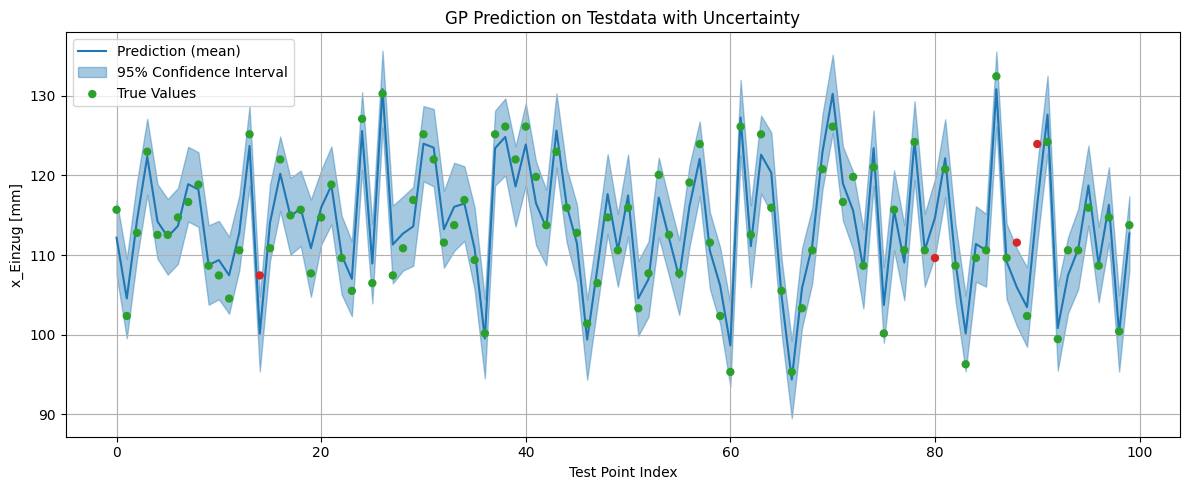

In [7]:
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_test), num_points, replace=False)
random_indices.sort()

# Predictive distribution for train data (no gradients required)
with torch.no_grad():
    f_preds = model(X_train_tensor)            # Latent function predictions
    y_preds = likelihood(f_preds)        # Observed predictions with noise

# Extract mean and standard deviation from predictions
train_mean = y_preds.mean.cpu().numpy()

# Calculate R² for the train data
r2_test = r2_score(y_train, train_mean)
print(f"R² on Train Data: {r2_test:.3f}")


means = means.numpy()
stddevs = stddevs.numpy()
# Calculate R² for the test data
r2_test = r2_score(y_test, means)
print(f"R² on Test Data: {r2_test:.3f}")

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
gp_lower = means - 2*stddevs
gp_upper = means + 2*stddevs

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (y_test >= gp_lower) & (y_test <= gp_upper)

counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= gp_lower[random_indices]) & (y_test[random_indices] <= gp_upper[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Plotting the prediction with uncertainty and true values
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)

# Plot predicted mean
plt.plot(x_axis, means[random_indices], label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, gp_lower[random_indices], gp_upper[random_indices],
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, y_test[random_indices], label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("GP Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()